# ADS Project 4: Machine Learning Fairness
## Spring 2023

In [ ]:
# Load modules
!pip install prince
import os, sys
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import A2_algorithm_function as ut
import A2_loss_function as lf
from A7_algorithm_function import *
import warnings
from c_svm import SVM
import matplotlib.pyplot as plt
from prince import CA

+ The cleaned COMPAS dataset is provided in `../output/compas-scores-two-years_cleaned.csv`. 

### Section 1: Load Data

In [2]:
df =  pd.read_csv('../output/compas-scores-two-years_cleaned.csv')
df.head(3)

,sex,age_cat,race,priors_count,c_charge_degree,two_year_recid,length_of_stay
0,Male,25 - 45,African-American,-0.733607,F,1,-0.167773
1,Male,< 25,African-American,0.055928,F,1,-0.340654
2,Male,25 - 45,Caucasian,2.029767,F,1,-0.244609


In [3]:
# change categorical data into numerical
le = LabelEncoder()
df['sex'] = le.fit_transform(df['sex'])
df['age_cat'] = le.fit_transform(df['age_cat'])
df['race'] = le.fit_transform(df['race'])
df['c_charge_degree'] = le.fit_transform(df['c_charge_degree'])

Encode categorical variables with numerical variables:
+ `sex`: 1 for male and 0 for female
+ `age_cat`: 2 for > 45, 0 for 25 - 45 and 1 for < 25
+ `race`: 1 for caucasian and 0 for african-american
+ `c_charge_degree`: 0 for F and 1 for M

In [4]:
# 
df['sex'].value_counts(), df['age_cat'].value_counts(), df['race'].value_counts(), df['c_charge_degree'].value_counts()

(1    4751
 0    1164
 Name: sex, dtype: int64,
 0    3378
 1    1281
 2    1256
 Name: age_cat, dtype: int64,
 0    3537
 1    2378
 Name: race, dtype: int64,
 0    3904
 1    2011
 Name: c_charge_degree, dtype: int64)

In [5]:
features = df[['sex', 'age_cat', 'c_charge_degree', 'length_of_stay',"priors_count"]]
sensitive = df['race']
target = df['two_year_recid']
X_train, X_test, y_train, y_test, race_train, race_test = \
    train_test_split(features, target, sensitive, test_size=0.3, random_state=6, shuffle = True)

+ **Protected**: Caucasians (i.e., `race == 1`)
+ **Not protected**: African-Americans (i.e., `race == 0`)

In [6]:
df.head()

,sex,age_cat,race,priors_count,c_charge_degree,two_year_recid,length_of_stay
0,1,0,0,-0.733607,0,1,-0.167773
1,1,1,0,0.055928,0,1,-0.340654
2,1,0,1,2.029767,0,1,-0.244609
3,0,0,1,-0.733607,1,0,-0.321445
4,1,1,1,-0.536224,0,1,-0.359864


The p-rule  function is commonly used in evaluate fairness in machine learning model, by checking whether the model's positive predictions are distributed similarly across different sensitive groups. The higher the p-rule, the better the fairness.

In [7]:
# Function to compute p-rule
def p_rule(sensitive_var, y_pred):
    protected = np.where(sensitive_var == 1)[0]
    not_protected = np.where(sensitive_var == 0)[0]
    protected_pred = np.where(y_pred[protected] == 1)
    not_protected_pred = np.where(y_pred[not_protected] == 1)
    protected_percent = protected_pred[0].shape[0]/protected.shape[0]
    not_protected_percent = not_protected_pred[0].shape[0]/not_protected.shape[0]
    ratio = min(protected_percent/not_protected_percent, not_protected_percent/protected_percent)
    
    return ratio, protected_percent, not_protected_percent

In [8]:
def calibration(y_true, y_pred, sensitive_features):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    c_index = np.where(sensitive_features == 1)[0]           
    a_index = np.where(sensitive_features == 0)[0]       
    
    y_pred_c = y_pred[c_index]           
    y_true_c = y_true[c_index] 
    acc_c = sum(y_pred_c == y_true_c)/len(y_pred_c)

    y_pred_a = y_pred[a_index]   
    y_true_a = y_true[a_index]
    acc_a = sum(y_pred_a == y_true_a)/len(y_pred_a)

    calibration = abs(acc_c - acc_a) * 100
    return(calibration)

The "80% rule" (or the p%-rule) is a guideline established by the U.S. Equal Employment Opportunity Commission (EEOC) to help identify potential discrimination in hiring, promotion, or other employment decisions. It's a way to measure fairness and equal opportunity in these processes, particularly concerning sensitive attributes such as race, gender, age, or disability.

### Section 2: Logistic Regression
#### 2.1 Baseline Model
First, we train a baseline model without constaint, and then evaluate it's accuaracy and fairness.

In [9]:
clf = LogisticRegression(random_state= 6).fit(X_train, y_train)
coeff = clf.coef_
intercept = clf.intercept_
optimal_loss = log_loss(y_train, clf.predict_proba(X_train))
print(f'The optimal loss of logistic model is: {optimal_loss}')

The optimal loss of logistic model is: 0.6407097826469522


+ Accuracy & Fairness check:

In [10]:
results_lr = {"Classifier": ["LR", "LR"], 
              "Set": ["Train", "Test"],
              "Accuracy (%)": [clf.score(X_train, y_train)*100, clf.score(X_test, y_test)*100],
              "P-rule (%)": [p_rule(race_train, clf.predict(X_train))[0]*100, p_rule(race_test, clf.predict(X_test))[0]*100],
              "Protected (%)": [p_rule(race_train, clf.predict(X_train))[1]*100, p_rule(race_test, clf.predict(X_test))[1]*100],
              "Not protected (%)": [p_rule(race_train, clf.predict(X_train))[2]*100, p_rule(race_test, clf.predict(X_test))[2]*100]}
pd.DataFrame(results_lr)

,Classifier,Set,Accuracy (%),P-rule (%),Protected (%),Not protected (%)
0,LR,Train,63.743961,55.108121,21.962896,39.854192
1,LR,Test,62.028169,59.382529,24.186704,40.730337


### Interpretation:

The p-rule, a fairness metric, indicates that there is some bias in the model (lower than 80%). This suggests that the classifier's performance could be improved in terms of both accuracy and fairness, particularly by addressing the disparity in positive outcomes between the protected and non-protected groups.

#### 2.2 Optimizing classifier accuracy subject to fairness constraints

The fairness constraint is set to achieve a 0 covariance between the sensitive feature (race) and the distance to the decision boundary. A 0 covariance means there is no correlation between the two variables, which helps promote fairness.

1. Train the model using constraints to extract model weights (cweight). 

In [11]:
# Setting Constrains
#In this case, only fairness constraints are applied (apply_fairness_constraints = 1)
# While accuracy constraint and separate constraint are not applied (both set to 0).
fairness_constraint = 1 
accuracy_constraint = 0
separate_constraint = 0
gamma = None
sensitive_attrs = ['race']
sensitive_attrs_to_cov_thresh = {'race': 0}
x_control = {'race': race_train}

In [12]:
# Training model with constraints
np.random.seed(704)
cweight = ut.train_model(X_train,
                   y_train,
                   x_control,
                   lf._logistic_loss,
                   fairness_constraint,
                   accuracy_constraint,
                   separate_constraint,
                   sensitive_attrs,
                   sensitive_attrs_to_cov_thresh,
                   gamma)

2. Feed the model with trained weights

In [13]:
# Feeding model with coefficients and weights
m = LogisticRegression()
m.coef_= cweight.reshape((1,-1))
m.intercept_ = 0
m.classes_ = np.array([0, 1])

+ Accuracy & Fairness check:

In [14]:
# Print the results
warnings.filterwarnings("ignore")
results_clr = {"Classifier": ["C-LR", "C-LR"],
               "Set": ["Train", "Test"],
               "Accuracy (%)": [m.score(X_train, y_train)*100, m.score(X_test, y_test)*100],
               "P-rule (%)": [p_rule(race_train, m.predict(X_train))[0]*100, p_rule(race_test, m.predict(X_test))[0]*100],
               "Protected (%)": [p_rule(race_train, m.predict(X_train))[1]*100, p_rule(race_test, m.predict(X_test))[1]*100],
               "Not protected (%)": [p_rule(race_train, m.predict(X_train))[2]*100, p_rule(race_test, m.predict(X_test))[2]*100]}
pd.DataFrame(results_clr)

,Classifier,Set,Accuracy (%),P-rule (%),Protected (%),Not protected (%)
0,C-LR,Train,48.405797,99.319527,94.733692,95.382746
1,C-LR,Test,49.633803,99.378233,95.190948,95.786517


### Interpretation:

The accuracy is lower compared to the based-model. Fairness wise, p-rule is drastically improved nearing 100% indicating the model is fair vis-a-vis to race.

### Section 3: Support Vector Machine (SVM) 
#### 3.1 Baseline Model

In [15]:
from sklearn import svm
from sklearn.svm import SVC

# Train model
svm_model = SVC(kernel = 'linear', probability = True)
clf= svm_model.fit(X_train, y_train)
optimal_loss = log_loss(y_train, clf.predict_proba(X_train))
print(f'The optimal loss of SVM model is: {optimal_loss}')

The optimal loss of SVM model is: 0.6445082714142158


In [16]:
# Display results
results_svm = {"Classifier": ["SVM", "SVM"],
               "Set": ["Train", "Test"],
               "Accuracy (%)": [clf.score(X_train, y_train)*100, clf.score(X_test, y_test)*100],
               "P-rule (%)": [p_rule(race_train, clf.predict(X_train))[0]*100, p_rule(race_test, clf.predict(X_test))[0]*100],
               "Protected (%)": [p_rule(race_train, clf.predict(X_train))[1]*100, p_rule(race_test, clf.predict(X_test))[1]*100],
               "Not protected (%)": [p_rule(race_train, clf.predict(X_train))[2]*100, p_rule(race_test, clf.predict(X_test))[2]*100]}
pd.DataFrame(results_svm)

,Classifier,Set,Accuracy (%),P-rule (%),Protected (%),Not protected (%)
0,SVM,Train,62.850242,51.049930,15.858767,31.065209
1,SVM,Test,61.352113,53.767411,17.821782,33.146067


#### 3.2 Optimizing SVM classifier accuracy subject to fairness constraints

In [17]:
# Fairness Constraints: Mechanisms for Fair Classification
svm = SVM()
x_control_train = {'race': race_train}
weights = svm.train(X_train, y_train, x_control_train, C=1, max_iter=100, lamb=1, gamma=None, apply_fairness_constraints=1, sensitive_attrs=['race'], sensitive_attrs_to_cov_thresh={'race': 0})
pred_y_test = np.sign(np.dot(X_test, weights))
pred_y_train = np.sign(np.dot(X_train, weights))
csvm_test_acc = sum(pred_y_test == y_test)/len(y_test)
csvm_train_acc = sum(pred_y_train == y_train)/len(y_train)

Running custom model


In [18]:
results_csvm = {"Classifier": ["C-SVM", "C-SVM"],
        "Set": ["Train", "Test"],
        "Accuracy (%)": [csvm_test_acc * 100, csvm_train_acc * 100],
        "Calibration(%)": [calibration(y_train, pred_y_train, race_train),
                                 calibration(y_test, pred_y_test, race_test)],
         "P-rule (%)": [p_rule(race_train, pred_y_train)[0]*100, p_rule(race_test, pred_y_test)[0]*100],
        "Protected (%)": [p_rule(race_train, pred_y_train)[1]*100, p_rule(race_test, pred_y_test)[1]*100],
        "Not protected (%)": [p_rule(race_train, pred_y_train)[2]*100, p_rule(race_test, pred_y_test)[2]*100]}



pd.DataFrame(results_csvm)

,Classifier,Set,Accuracy (%),Calibration(%),P-rule (%),Protected (%),Not protected (%)
0,C-SVM,Train,47.042254,14.350005,99.488510,94.733692,95.220737
1,C-SVM,Test,45.362319,11.422029,98.986143,94.908062,95.880150


### Section 4: Information Theoretic Measures for Fairness-aware Feature Selection(FFS) 

An another method to deal with machine learning fairness is called **Information Theoretic Measures for Fairness-aware Feature selection (FFS)**. 

In short, from the joint statistics of the data, the framework proposes that two information theoretic measures can be used to quantify the **accuracy** and **discrmination** aspect for each subset of the feature space. We then compute the **Shapley coefficients** for each feature to capture its effect on the sensitive/protected group.

Below is how we choose features by using **FFS** Algorithm.

In [17]:
# this code block takes ~ 20 min to run, so we directly load results from local file
y=df["two_year_recid"]
y=y.to_numpy()
y=np.reshape(y,(-1,1))

a=df["race"]
a=a.to_numpy()
a=np.reshape(a,(-1,1))

arr=["sex","age_cat","priors_count","c_charge_degree","length_of_stay"]

for i in arr:
    print("Feature:",end="")
    print(i)
    print("Marginal Accuracy Coefficient:",end="")
    print(shapley_accuracy(i,y,a))
    print("Marginal Discrimination Coefficient:",end="")
    print(shapley_discrimination(i,y,a))

Feature:sex
Marginal Accuracy Coefficient:0.003568314907946012
Marginal Discrimination Coefficient:8.16082890138538e-06
Feature:age_cat
Marginal Accuracy Coefficient:0.011273246895526084
Marginal Discrimination Coefficient:4.4881509198872635e-05
Feature:priors_count
Marginal Accuracy Coefficient:0.02427159853758174
Marginal Discrimination Coefficient:4.464995590653898e-05
Feature:c_charge_degree
Marginal Accuracy Coefficient:0.001958893676796756
Marginal Discrimination Coefficient:6.936830123648318e-06
Feature:length_of_stay
Marginal Accuracy Coefficient:0.005168319175750994
Marginal Discrimination Coefficient:1.0984742883746511e-05


In [19]:
# display result
shapley_results = pd.DataFrame()
arr=["sex","age_cat","priors_count","c_charge_degree","length_of_stay"]

shapley_results["Feature"] = arr
shapley_results["Accuracy Coefficient"] = [0.003568314907946012, 0.011273246895526084,0.02427159853758174,0.001958893676796756,0.005168319175750994]
shapley_results["Discrimination Coefficient"] = [8.16082890138538e-06,4.4881509198872635e-05,4.464995590653898e-05,6.936830123648318e-06,1.0984742883746511e-05]
shapley_results

,Feature,Accuracy Coefficient,Discrimination Coefficient
0,sex,0.003568,0.000008
1,age_cat,0.011273,0.000045
2,priors_count,0.024272,0.000045
3,c_charge_degree,0.001959,0.000007
4,length_of_stay,0.005168,0.000011


From the table above, we can see that **Discrimination Coefficient** of `priors_count` is highest, but **Accuracy Coefficient** is also high, so we can't ignore this feature. `length_of_stay` has a little high **Discrimination Coefficient**, and its **Accuracy Coefficient** is low, so we can ignore this feature. So finally, we can choose these four features:

- `priors_count`
- `age_cat`
- `sex`
- `c_charge_degree`

#### 4.1 Logistic Regression using FFS

In [20]:
features = df[['sex', 'age_cat', 'c_charge_degree', 'priors_count']]
sensitive = df['race']
target = df['two_year_recid']
X_train, X_test, y_train, y_test, race_train, race_test = \
    train_test_split(features, target, sensitive, test_size=0.3, random_state=6, shuffle = True)

In [21]:
# Train model and print results
clf = LogisticRegression(random_state = 0).fit(X_train, y_train)
coeff = clf.coef_
intercept = clf.intercept_
optimal_loss = log_loss(y_train, clf.predict_proba(X_train))
print(f'The optimal loss of logistic model is: {optimal_loss}')

# Display results
results_ffs_lr = {"Classifier": ["FFS-LR", "FFS-LR"],
                  "Set": ["Train", "Test"],
                  "Accuracy (%)": [clf.score(X_train, y_train)*100, clf.score(X_test, y_test)*100],
                  "P-rule (%)": [p_rule(race_train, clf.predict(X_train))[0]*100, p_rule(race_test, clf.predict(X_test))[0]*100],
                  "Protected (%)": [p_rule(race_train, clf.predict(X_train))[1]*100, p_rule(race_test, clf.predict(X_test))[1]*100],
                  "Not protected (%)": [p_rule(race_train, clf.predict(X_train))[2]*100, p_rule(race_test, clf.predict(X_test))[2]*100]}
pd.DataFrame(results_ffs_lr)

The optimal loss of logistic model is: 0.6436511330361576


,Classifier,Set,Accuracy (%),P-rule (%),Protected (%),Not protected (%)
0,FFS-LR,Train,63.405797,58.808292,23.937762,40.704739
1,FFS-LR,Test,61.802817,65.541470,26.449788,40.355805


#### 4.2 SVM using FFS

In [81]:
# Train model
svm_model = SVC(kernel = 'linear', probability = True)
clf= svm_model.fit(X_train, y_train)
optimal_loss = log_loss(y_train, clf.predict_proba(X_train))
print(f'The optimal loss of SVM model is: {optimal_loss}')

# Display results
results_ffs_svm = {"Classifier": ["FFS-SVM", "FFS-SVM"],
               "Set": ["Train", "Test"],
               "Accuracy (%)": [clf.score(X_train, y_train)*100, clf.score(X_test, y_test)*100],
               "P-rule (%)": [p_rule(race_train, clf.predict(X_train))[0]*100, p_rule(race_test, clf.predict(X_test))[0]*100],
               "Protected (%)": [p_rule(race_train, clf.predict(X_train))[1]*100, p_rule(race_test, clf.predict(X_test))[1]*100],
               "Not protected (%)": [p_rule(race_train, clf.predict(X_train))[2]*100, p_rule(race_test, clf.predict(X_test))[2]*100]}
pd.DataFrame(results_ffs_svm)

The optimal loss of SVM model is: 0.647671669776638


,Classifier,Set,Accuracy (%),P-rule (%),Protected (%),Not protected (%)
0,FFS-SVM,Train,62.463768,50.574145,15.260323,30.174160
1,FFS-SVM,Test,61.183099,57.589169,18.387553,31.928839


### Section 5: Evaluation

In this session, we compare all models from paper A2 and A7 using both accuracy and P-rule score as a measure of fairnes. 

In [82]:
results = [results_lr, results_clr, results_svm, results_csvm, results_ffs_lr, results_ffs_svm]
results_df = [pd.DataFrame(r) for r in results]

results_combined = pd.concat(results_df, axis=0)
results_combined = results_combined[results_combined["Set"] == "Test"]
results_combined = results_combined.drop(columns=["Set", "Calibration(%)"])

results_combined

,Classifier,Accuracy (%),P-rule (%),Protected (%),Not protected (%)
1,LR,62.028169,59.382529,24.186704,40.730337
1,C-LR,49.633803,99.378233,95.190948,95.786517
1,SVM,61.352113,53.767411,17.821782,33.146067
1,C-SVM,45.362319,98.986143,94.908062,95.880150
1,FFS-LR,61.802817,65.541470,26.449788,40.355805
1,FFS-SVM,61.183099,57.589169,18.387553,31.928839


If we take both accuracy and fairness into account, we would recommend FFS-LR with 61.8% accuracy as the second highest of all models, and with p-rule score 65.54% that's reasonably well (third highest of all models). 

The reason we don't choose C-LR or C-SVM is because despite their high P-rule value, their accuracy is too low for a binary classifier. The reason we don't choose traditional LR or SVM is because despite their relative high accuracy, they do not take fairness into account.

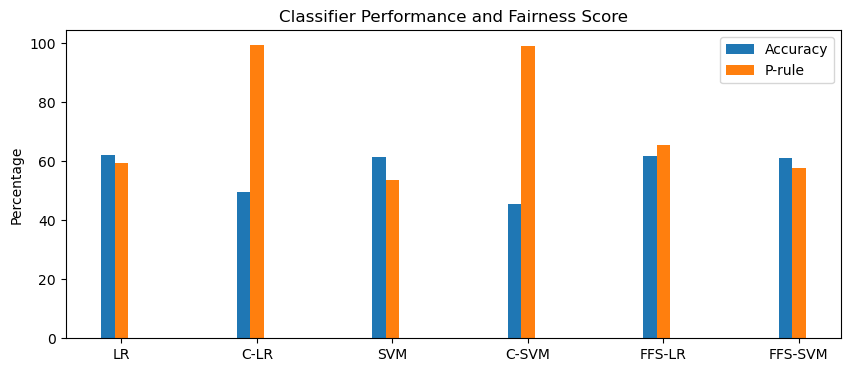

In [84]:
fig, ax = plt.subplots(figsize = (10,4))
x = range(len(results_combined.index))

width = 0.1
ax.bar(x, results_combined['Accuracy (%)'], width, label='Accuracy')
ax.bar([i + width for i in x], results_combined['P-rule (%)'], width, label='P-rule')

ax.set_xticks([i + width for i in x])
ax.set_xticklabels(results_combined['Classifier'])
ax.legend()

plt.ylabel("Percentage")
plt.title("Classifier Performance and Fairness Score")

plt.show()